# 2020 Covid dataset analysed


## Part 1 - Feature Engineering 

In [19]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
list_of_df= []
for (root, dirs, files) in os.walk(os.path.join(os.getcwd(), "county_data")):
    for file in files:
        if file[-4:] == ".csv": 
            df = pd.read_csv(os.path.join(root, file))
            df = df.dropna()
            if len(df):
                name = df["areaName"][5]
                df = df.drop(df.columns[:3], axis=1)[::-1].reset_index(drop=True)
                df['y'] = df["newCasesBySpecimenDate"]/df["newVirusTestsBySpecimenDate"]
                df.columns=['Date','Cases','Deaths','Tests','y']
                #df=df.set_index('Date')
                list_of_df.append([name,df])




In [3]:
list_of_df[0][1]

,Date,Cases,Deaths,Tests,y
0,2020-03-20,1.0,1.0,4,0.250000
1,2020-03-21,0.0,1.0,5,0.000000
2,2020-03-22,0.0,0.0,9,0.000000
3,2020-03-23,0.0,0.0,11,0.000000
4,2020-03-24,0.0,0.0,11,0.000000
...,...,...,...,...,...
965,2022-11-10,11.0,0.0,66,0.166667
966,2022-11-11,0.0,0.0,45,0.000000
967,2022-11-12,5.0,0.0,176,0.028409
968,2022-11-13,3.0,0.0,32,0.093750


In [5]:
list_of_features=['Cases','Deaths','Tests']
list_county=[x[0] for x in list_of_df]

def norm_feature(data,col=None):
    '''
    Given a DataFrame and a column, it normalises the data in a new column called NORM_column
    '''
    if col is None:
        a=(data-data.mean())/data.std()
    else: 
        a=(data[col]-data[col].mean())/data[col].std()
    name='NORM_'+ col
    data[name]=a
    return data

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

features=[]
for name,df in list_of_df:
    for feature in list_of_features:
        a='NORM_'+feature
        if a not in features:
            features.append(a)
        if a not in df.columns:
            df = norm_feature(df, col=feature)


In [6]:
list_of_df[0][1].describe()


,Cases,Deaths,Tests,y,NORM_Cases,NORM_Deaths,NORM_Tests
count,970.000000,970.000000,970.000000,970.000000,9.700000e+02,9.700000e+02,9.700000e+02
mean,37.091753,0.380412,806.815464,0.067686,1.602384e-18,-2.283740e-15,2.815617e-17
std,61.640514,0.844229,743.090305,0.114433,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,0.000000,4.000000,0.000000,-6.017431e-01,-4.506034e-01,-1.080374e+00
25%,6.000000,0.000000,167.250000,0.021164,-5.044045e-01,-4.506034e-01,-8.606834e-01
50%,20.000000,0.000000,560.500000,0.042134,-2.772811e-01,-4.506034e-01,-3.314745e-01
75%,45.000000,0.000000,1324.500000,0.076801,1.282963e-01,-4.506034e-01,6.966644e-01
max,839.000000,10.000000,3686.000000,2.000000,1.300943e+01,1.139453e+01,3.874609e+00


In [89]:
from warnings import simplefilter
import seaborn as sns
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


def pipeline(model, county):
    # def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    #     palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    #     if palette_kwargs is not None:
    #         palette_kwargs_.update(palette_kwargs)
    #     palette = sns.color_palette(**palette_kwargs_)
    #     if ax is None:
    #         fig, ax = plt.subplots()
    #     ax.set_prop_cycle(plt.cycler('color', palette))
    #     for date, preds in y[::every].iterrows():
    #         preds.index = pd.period_range(start=date, periods=len(preds))
    #         preds.plot(ax=ax)
    #     return ax

    def make_lags(ts, lags, lead_time=1):
        return pd.concat(
            {
                f'y_lag_{i}': ts.shift(i)
                for i in range(lead_time, lags + lead_time)
            },
            axis=1)

    # 14 days of lag features
    y = county.y.copy()*1000
    X = make_lags(y, lags=50).fillna(0.0)

    def make_multistep_target(ts, steps):
        return pd.concat(
            {f'y_step_{i + 1}': ts.shift(-i)
            for i in range(steps)},
            axis=1)

    # Eight-week forecast
    y = make_multistep_target(y, steps=30).dropna()

    # Shifting has created indexes that don't match. Only keep times for
    # which we have both targets and features.
    y, X = y.align(X, join='inner', axis=0)

    # Create splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
    
    model.fit(X_train, y_train)

    y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
    y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

    # train_rmse = mean_squared_error(y_train, y_fit, squared=False)
    # test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    # print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

    #palette = dict(palette='husl', n_colors=64)
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
    #ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
    #ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
    #_ = ax1.legend(['FluVisits (train)', 'Forecast'])
    #ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
    #ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
    #_ = ax2.legend(['FluVisits (test)', 'Forecast'])
    return model

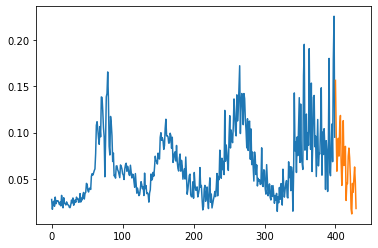

In [90]:
model = LinearRegression()
for i in range(len(list_of_df)//9):
    model = pipeline(model, list_of_df[i][1])


past_values = 50
def get_data(n):
    values=list(list_of_df[n][1].y)
    X = []
    y = []
    for i in range(len(values)-past_values):
        X.append(values[i:i+past_values])
        y.append(values[i+past_values])
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = get_data(100)
# X, y = X[:-220], y[:-220]

plt.plot(y[-400:])

shift = 0
x_axis_future = np.arange(400-30*shift, 400-30*(shift-1))
if shift: y_future = model.predict(X[-1-shift:-shift])/1000
else: y_future = model.predict(X[-1-shift:]*1000)/1000
plt.plot(x_axis_future, y_future[0])
if shift == 0: y = np.append(y, y_future)

In [97]:
prediction_dict = {}
for i in range(len(list_of_df)):
    past_values = 50
    X, y = get_data(i)
    y_future = model.predict(X[-1:]*1000)/1000
    y_future = y_future[0]
    for j, val in enumerate(y_future):
        if val < 0: y_future[j] = 0
    prediction_dict[list_of_df[i][0]] = y_future

In [98]:
prediction_dict["Cambridgeshire"]

array([0.11683659, 0.0858916 , 0.08505923, 0.10670617, 0.11082837,
       0.09797741, 0.09653384, 0.09644207, 0.08232884, 0.06982758,
       0.08843001, 0.09066327, 0.06548899, 0.06731322, 0.09379801,
       0.07478201, 0.05365488, 0.07418613, 0.08373245, 0.07528676,
       0.04893074, 0.05086003, 0.04168411, 0.05681954, 0.06157288,
       0.07679225, 0.04848178, 0.05453162, 0.040218  , 0.04170418])

In [99]:
max=0
min=100
for county in prediction_dict:
    max = np.max(np.array([max, np.max(prediction_dict[county])]))
    min = np.min(np.array([min, np.min(prediction_dict[county])]))
print(min, max)

0.0 0.20172722025749484
